In [196]:
#GENERAL LIBRARIES
import pandas as pd
import numpy as np
import time
import datetime
from dotenv import load_dotenv
import os
import statistics
import scipy.stats


#ML LIBRARIES
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#PLOTING LIBRARIES
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style


#DATA REQUESTING LIBRARIES
import quandl
from yahoofinancials import YahooFinancials
import intrinio_sdk


#TWITTER SENTIMENT ANALYSIS LIBRARIES
import tweepy as tw
from textblob import TextBlob

In [216]:
# GETS THE API KEY FROM .ENV FILE
def get_key(d_key):
    load_dotenv('.env')
    key = os.environ.get(d_key)
    return key


# GETS DATA FROM QUANDL / DEFAULT IS BOING DATA 
def quandl_get(code="EOD/BA", start_date="1970-01-01", end_date=str(datetime.datetime.now().date())):
    return quandl.get(code, start_date=start_date, end_date=end_date)


# GETS DATA FROM YAHOOFINANCIALS
def yahoo_get(ticker='AAPL', start='1970-01-01', end=str(datetime.datetime.now().date())):
    yahoo_financials = YahooFinancials(ticker)
    dic = yahoo_financials.get_historical_price_data(start, end, 'daily')
    df = pd.DataFrame(dic[ticker]['prices'])
    df['Date'] = pd.to_datetime(df['date'], unit='s').dt.date
    df.drop(columns=['formatted_date', 'date'], inplace=True)
    return df


# CONNECTS TO TWITTER API
def twitter():
    consumer_key = get_key('twitter_api')
    consumer_secret = get_key('twitter_api_secret')
    access_token = get_key('twitter_access_token')
    access_token_secret = get_key('twitter_access_token_secret')
    auth = tw.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tw.API(auth, wait_on_rate_limit=True)
    return api

    
# RETRIEVES ALL TWEETS WITH HASHTAG   
def get_tweets_hash(hashtag, api):
    tmp = []
    for tweet in tw.Cursor(api.search,q=hashtag ,count=100, lang="en",
                           since=str(datetime.datetime.now().date()-datetime.timedelta(days=15)),
                           tweet_mode='extended').items():
        tmp.append((tweet.created_at, tweet.full_text))
        
    df = pd.DataFrame(tmp)
    df['date'] = df[0].dt.date
    group = df.groupby(['date']).sum()
    group['Sentiment'] = group[1].apply(sentiment)
    group.columns = ['Tweets', 'Sentiment']
    return group


# KEEP SIGNIFICANT COLUMNS. ADD CHANGE AND VOLATILITY
def feature_eng_quandl(df, n=10):
    df['Volatility'] = (df['Adj_High'] - df['Adj_Low']) / df['Adj_Low']
    df['Change'] = (df['Adj_Close'] - df['Adj_Open']) / df['Adj_Open']
    df = df[['Adj_Close', 'Volatility', 'Change', 'Adj_Volume']]
    df['20ma'] = df['Adj_Close'].rolling(window=20, min_periods=0).mean()
    df.fillna('-999999', inplace=True) # N/A value treated as outlier
    #Defines forecast to predict
    forecast_column = 'Adj_Close'
    #shifts label to the past n days
    df['future_price{}d'.format(n)] = df[forecast_column].shift(-n)
    return df


# KEEP SIGNIFICANT COLUMNS. ADD CHANGE AND VOLATILITY
def feature_eng_yahoo(df, n=5):
    df.index = df['Date']
    df['Volatility'] = (df['high'] - df['low']) / df['low']
    df['Change'] = (df['close'] - df['open']) / df['open']
    df = df[['close', 'Volatility', 'Change', 'volume']]
    df.columns = ['Adj_Close', 'Volatility', 'Change', 'Adj_Volume']
    df['20ma'] = df['Adj_Close'].rolling(window=20, min_periods=0).mean()
    df.fillna('-999999', inplace=True) # N/A value treated as outlier
    #Defines forecast to predict
    forecast_column = 'Adj_Close'
    #shifts label to the past n days
    df['future_price{}d'.format(n)] = df[forecast_column].shift(-n)
    return df    
 
    
#PLOTS CORRELATION HEATMAP AND SAVES
def plot_corr(df,size=10, title = 'Correlation'):
    style.use('ggplot')
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax = sns.heatmap(corr, annot=True, cmap="Blues").set_title(title)
    fig.savefig('images/corr_heatmap.png')

    
#TRAIN LSTM 
def LSTM_train(data):
    df = data.dropna()
    X = df.drop('future_price10d', axis=1)
    y = df['future_price10d']
    X_train, X_test = X[:int(-0.1*len(X))], X[int(-0.1*(len(X))):]
    y_train, y_test = y[:int(-0.1*len(X))], y[int(-0.1*(len(X))):]
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=4, batch_size=1, verbose=2)
    score, acc = model.evaluate(X_test, y_test,batch_size=batch_size)
    print('''----- * SCORE & ACCURACY * -----\n\nScore: {}%  Accuracy: {}%
          \n\n----- * SCORE & ACCURACY * -----'''.format(round(score*100,2), round(acc*100,2)))
    return model, score, acc



#TRAIN LINEAR REGRESSION 
def LR_train(data,d):
    df = data.dropna()
    X = df.drop('future_price{}d'.format(d), axis=1)
    y = df['future_price{}d'.format(d)]
    X_train, X_test = X[:int(-0.2*len(X))], X[int(-0.2*(len(X))):]
    y_train, y_test = y[:int(-0.2*len(X))], y[int(-0.2*(len(X))):]
    reg = LinearRegression(n_jobs=-1)
    reg.fit(X_train, y_train)
    score = reg.score(X_test, y_test)
    print('----- * SCORE * -----\n\n{}%\n\n----- * SCORE * -----'.format(round(score*100,2)))
    return score, reg



#PREDICT FUTURE VALUES
def LR_predict(df, reg, d):
    X = df.drop('future_price{}d'.format(d), axis=1)
    y = df['future_price{}d'.format(d)]
    X_predict = X[-d:]
    reg = LinearRegression(n_jobs=-1)
    reg.fit(X[:-d], y[:-d])
    predictions = reg.predict(X_predict)
    prediction_column = [np.nan for _ in range(len(df)-d)]
    prediction_column.extend(predictions)
    df['Predictions'] = prediction_column
    return predictions, df



#PLOT STOCK PRICE VS TIME
def plot_stock(df, col, size=15, title='Stock'):
    fig = plt.figure(figsize=(size,size))
    style.use('ggplot')
    ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
    ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)
    fig.suptitle(title)
    ax1.plot(df.index, df[col])
    ax1.plot(df.index, df['20ma'])
    plt.xticks(rotation=90)
    ax2.bar(df.index, df['Adj_Volume'])
    fig.autofmt_xdate()
    plt.show()
    fig.savefig('images/{}.png'.format(title))

    
    
#PLOT PREDICTIONS
def plot_predictions(df, col, size=10, title='Stock-Predictions'):
    fig = plt.figure(figsize=(size,size))
    style.use('ggplot')
    ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
    ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)
    fig.suptitle(title)
    ax1.plot(df.index[-30:]+datetime.timedelta(days=5), df[col][-30:])
    ax1.plot(df.index[-30:], df['20ma'][-30:])
    plt.xticks(rotation=90)
    ax2.bar(df.index[-30:], df['Adj_Volume'][-30:])
    fig.autofmt_xdate()
    plt.show()
    fig.savefig('images/{}.png'.format(title))

    
    
#SENTIMENT ANALYSIS
def sentiment(text):
    tweets = TextBlob(str(text))
    return tweets.sentiment.polarity


#DISPLAY SUMMARY TABLES
def summary(df_clean, tw, pred, days=5):
    df = df_clean.tail(len(tw)).copy()
    res = pd.concat([df, tw], axis=1, sort=True)
    part1 = res[['Adj_Close', 'Volatility', 'Change', 'Adj_Volume', '20ma']].fillna('Market Closed')
    part2 = res[['future_price{}d'.format(days), 'Predictions', 'Tweets', 'Sentiment']].fillna('Unknown')
    res = pd.concat([part1, part2], axis=1, sort=True)
    
    dates = [datetime.datetime.now().date() + datetime.timedelta(days=i) for i in range(days)]    
    predictions = pd.DataFrame(pred)
    predictions.index = dates
    predictions.columns = ['Stock-Predicted']
    return res[:-1], predictions



# MARKOFF CHAIN MONTE CARLO SIMULATION
def mcmc(df, days=1000):
    df['change_ratio'] = (df['close']-df['open'])/df['open']
    stats = df['change_ratio'].describe()
    mu, sigma = stats['mean'], stats['std']

    # plots stock's change histogram
    fig, ax = plt.subplots(figsize=(10, 5))
    style.use('ggplot')
    sns.distplot(df['change_ratio'])
    ax.set_xlabel('Change / OpenPrice')
    ax.set_ylabel('Probability density')
    ax.set_title('Histogram of {} stock change ratio:\n $\mu={}$, $\sigma={}$'.format(ticker,round(mu,7),round(sigma,3)))
    fig.savefig('images/Histogram of {} stock change ratio: mu={}, sigma={}.png'.format(ticker,round(mu,7),round(sigma,3)))
    
    # Montecarlo simulation
    sample = mu + sigma * np.random.randn()
    tomorrow = df['close'][-1] + df['close'][-1]*sample
    res = []
    end = []
    for scene in range(500):
        evo = []
        future = tomorrow
        for day in range(days):
            sample = mu + sigma * np.random.randn()
            future += future*sample
            evo.append(future)
        res.append(evo)
        end.append(evo[-1])
    results = pd.DataFrame(res).T
    
    # Plot MCMC simulations
    fig, ax = plt.subplots(figsize=(15,10))
    plt.plot(results, alpha=0.4)
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Stock Price ')
    plt.title('MCMC of {} stock price'.format(ticker))
    plt.show()
    fig.savefig('images/MCMC of {} stock price.png'.format(ticker))
    
    #Plot results histogram
    mean = statistics.mean(end)
    std = statistics.stdev(end)
    fig, ax = plt.subplots(figsize=(10, 5))
    style.use('ggplot')
    sns.distplot(end)
    ax.set_xlabel('Price {} days into the future'.format(days))
    ax.set_ylabel('Probability density')
    ax.set_title('Histogram of {} future price :\n $\mu={}$, $\sigma={}$'.format(ticker,round(mean,2),round(std,2)))
    fig.savefig('images/Histogram of {} future price :mu={},sigma={}.png'.format(ticker,round(mean,2),round(std,2)))
    
    # Probability table
    table = []
    for i in range(10):
        table.append((round(1-i/10,2), scipy.stats.norm.ppf(i/10,mean,std)))

    prob_table = pd.DataFrame(table)
    prob_table.columns = ['Probability', 'Min. Price']
    prob_table.set_index('Probability', inplace=True)
    display(prob_table)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


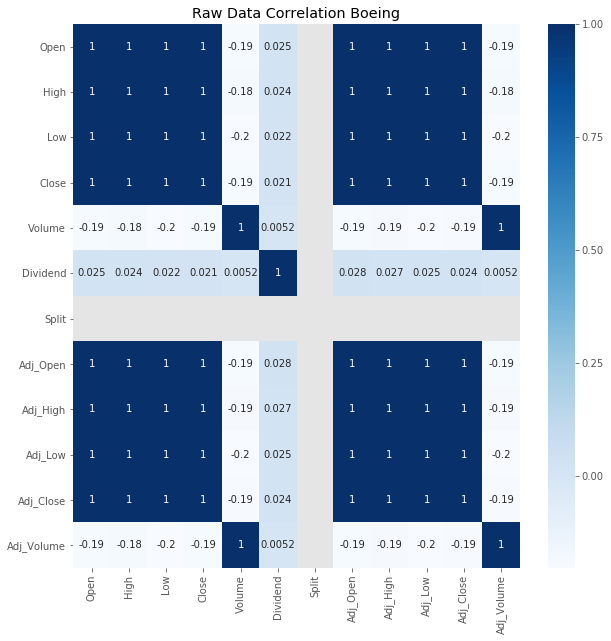

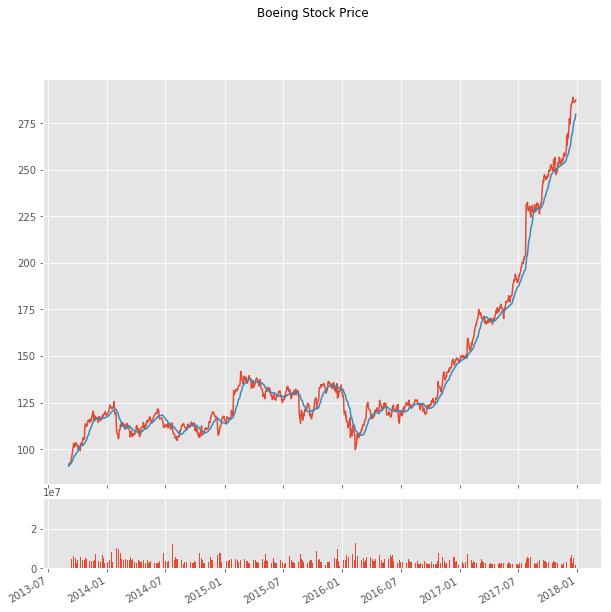

----- * SCORE * -----

95.61%

----- * SCORE * -----


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


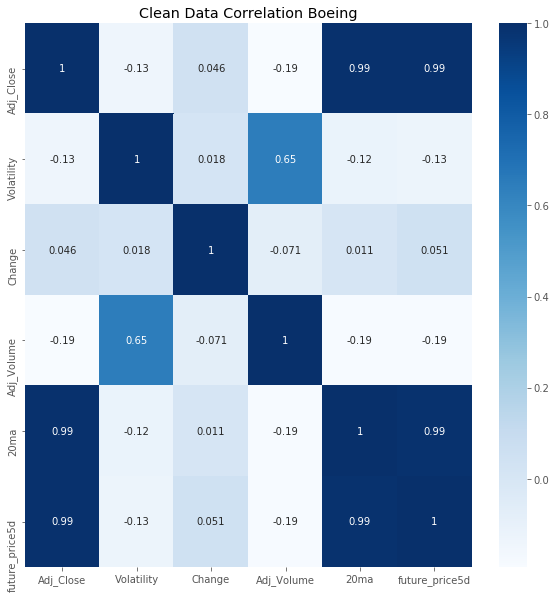

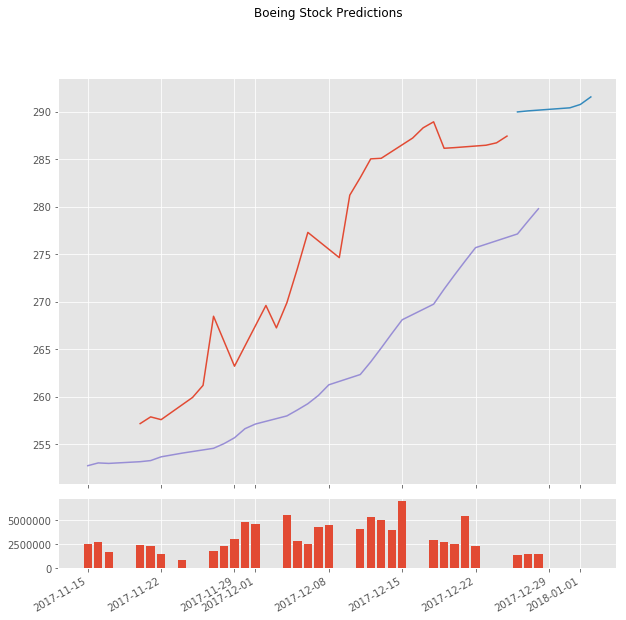

In [213]:
if __name__ == "__main__":
    
    #Define the forecast that the model is train to predict
    days_predict = 5
    
    #Request Quandl for the BOEING COMPANY historic data
    quandl_key = get_key('quandl_key')
    quandl.ApiConfig.api_key = quandl_key
    boeing = quandl_get('EOD/BA')
    
    #Plot data and feature correlation, clean data and featurure engineering
    plot_corr(boeing, 10, 'Raw Data Correlation Boeing')
    boeing_clean = feature_eng_quandl(boeing, days_predict)
    plot_stock(boeing_clean, 'Adj_Close',10,'Boeing Stock Price')
    plot_corr(boeing_clean, 10,'Clean Data Correlation Boeing')
    
    #Train model and predict Close Stock Prices BA
    score_boeing, reg_boeing = LR_train(boeing_clean, days_predict)
    predictions_boeing, boeing_predicted = LR_predict(boeing_clean, reg_boeing, days_predict)
    plot_predictions(boeing_predicted,['future_price{}d'.format(days_predict), 'Predictions'] , 10, 'Boeing Stock Predictions')
    
    
    #Retrieve related tweets
    api = twitter()
    boeing_tw = get_tweets_hash('#BA', api)
    
    #Create summary dataframe
    boeing_sum = summary(boeing_clean, boeing_tw, predictions_boeing)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


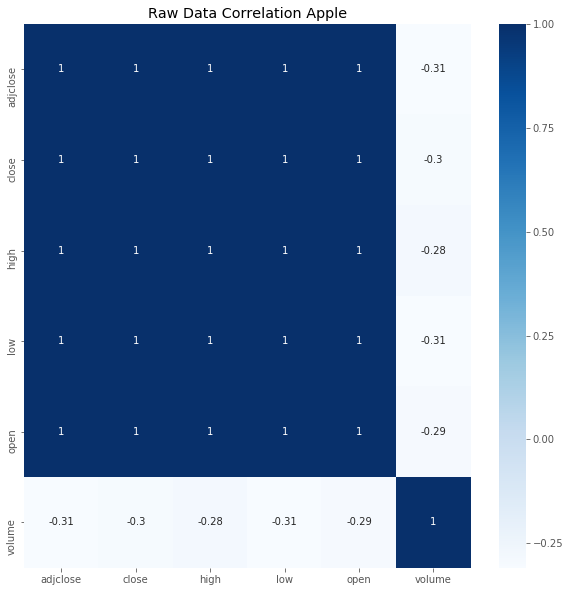

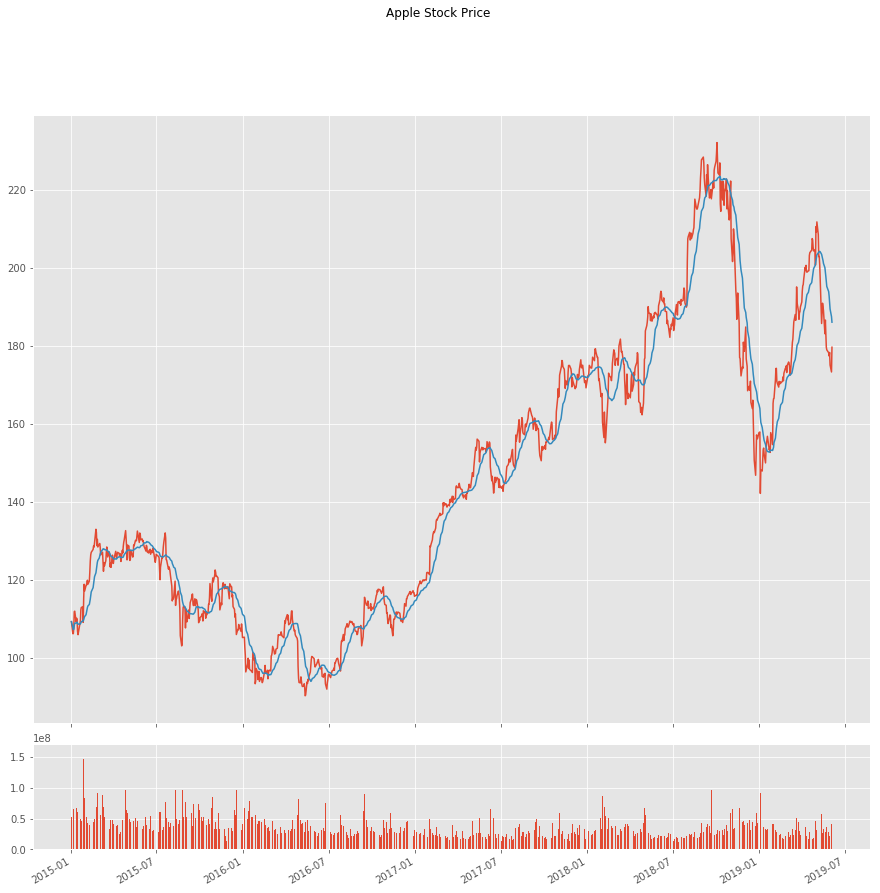

----- * SCORE * -----

87.87%

----- * SCORE * -----


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


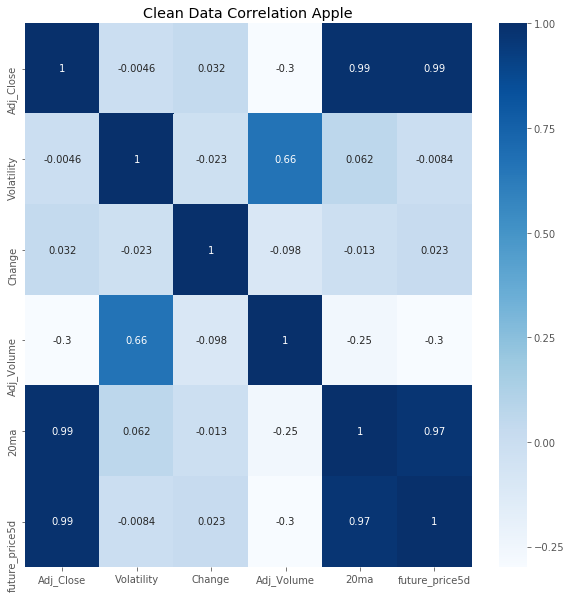

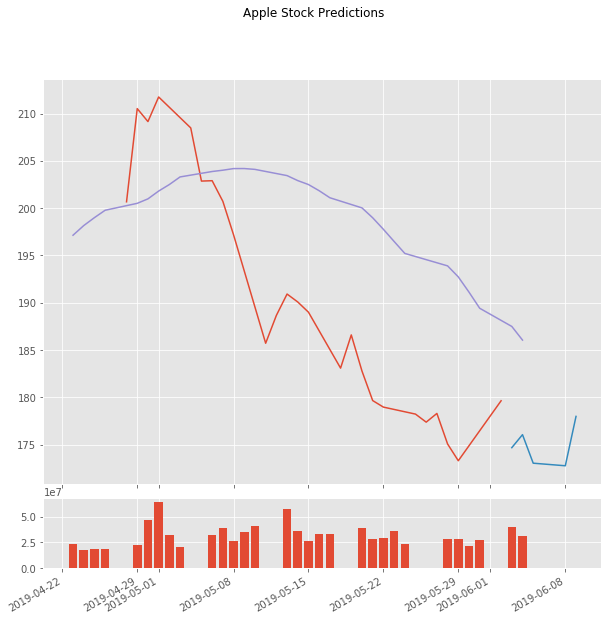

In [214]:
if __name__ == "__main__":
    #Request YahooFinance library for Apples's historic data
    apple = yahoo_get('AAPL', '2015-01-01', str(datetime.datetime.now().date()))
    plot_corr(apple, 10, 'Raw Data Correlation Apple')
    apple_clean = feature_eng_yahoo(apple, days_predict)
    plot_stock(apple_clean, 'Adj_Close', 15 ,'Apple Stock Price')
    plot_corr(apple_clean, 10,'Clean Data Correlation Apple')
    
    #Train model and predict Close Stock Prices AAPL
    score_apple, reg_apple = LR_train(apple_clean, days_predict)
    predictions_apple, apple_predicted = LR_predict(apple_clean, reg_apple, days_predict)
    plot_predictions(apple_predicted,['future_price{}d'.format(days_predict), 'Predictions'] , 10, 'Apple Stock Predictions')
    
    #Retrieve related tweets
    api = twitter()
    appl_tw = get_tweets_hash('#AAPL', api)
    
    #Create summary dataframe
    apple_sum = summary(apple_clean, appl_tw, predictions_apple)

Company's Stock Ticker: GOOGL
Prediction range (days): 5
MCMC simulation (days): 1000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


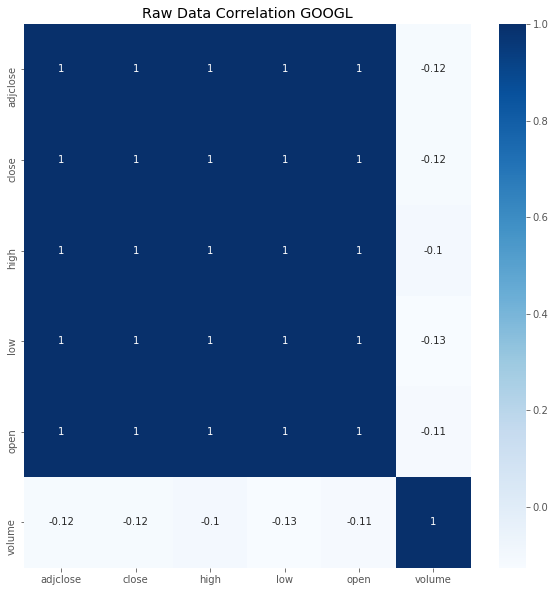

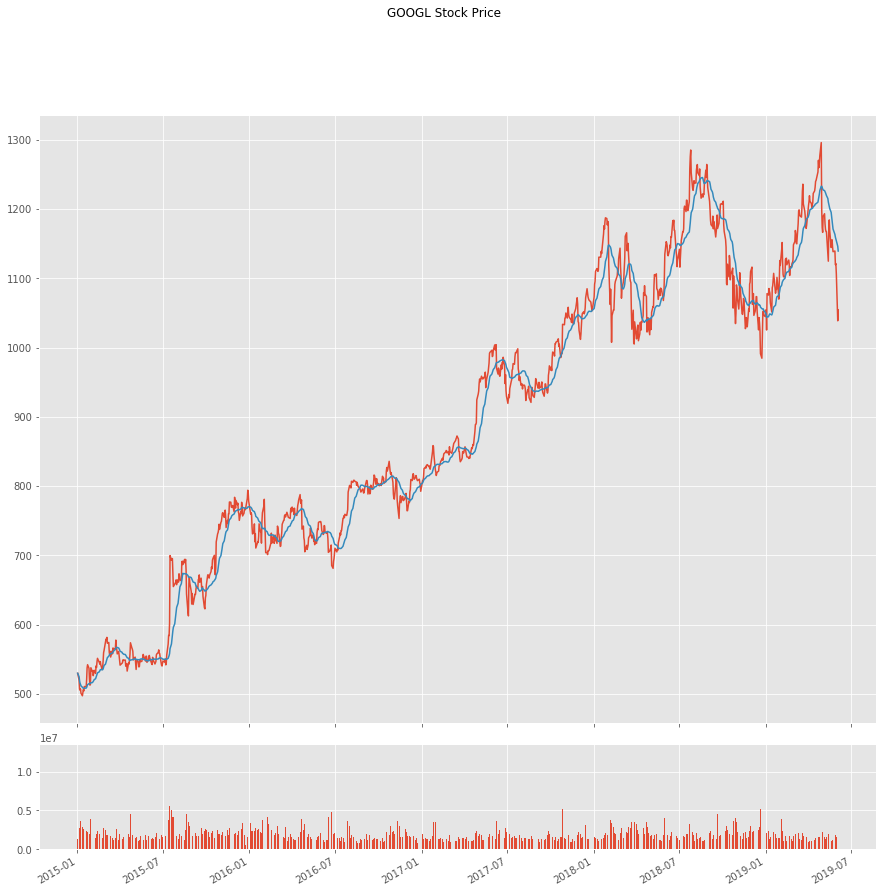

----- * SCORE * -----

71.07%

----- * SCORE * -----


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


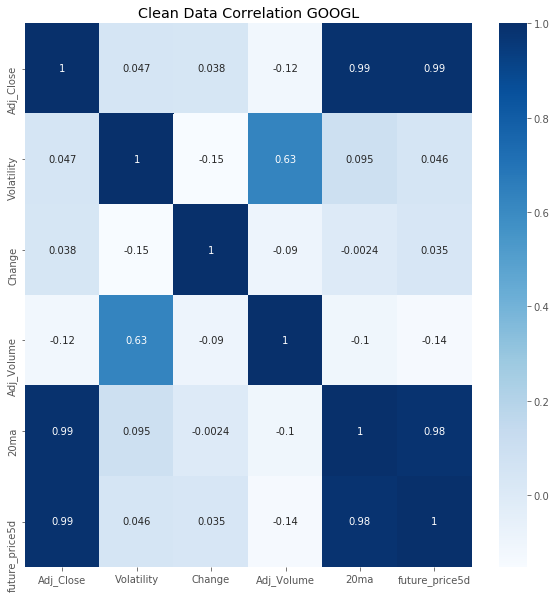

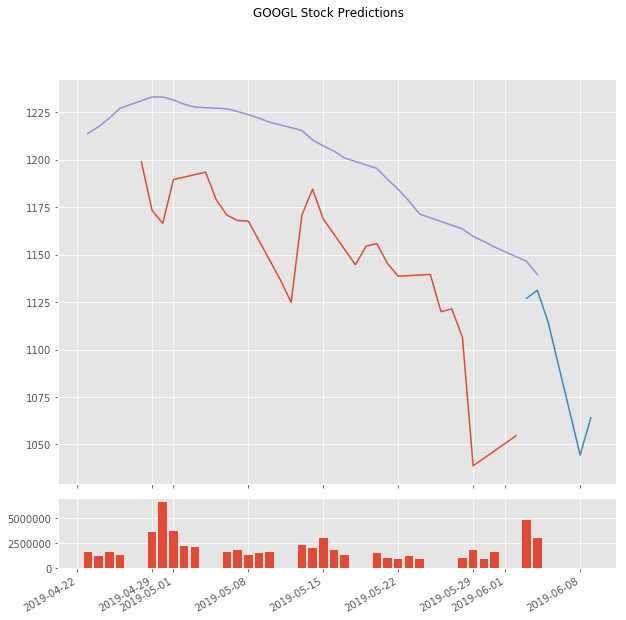

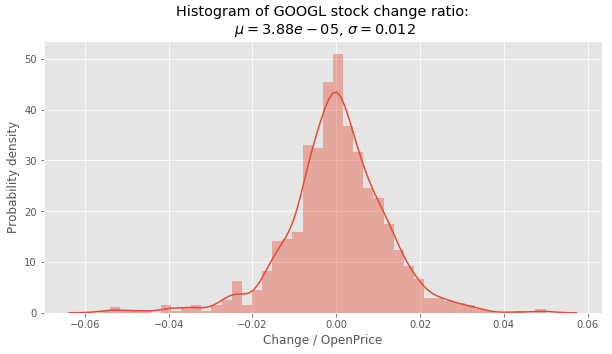

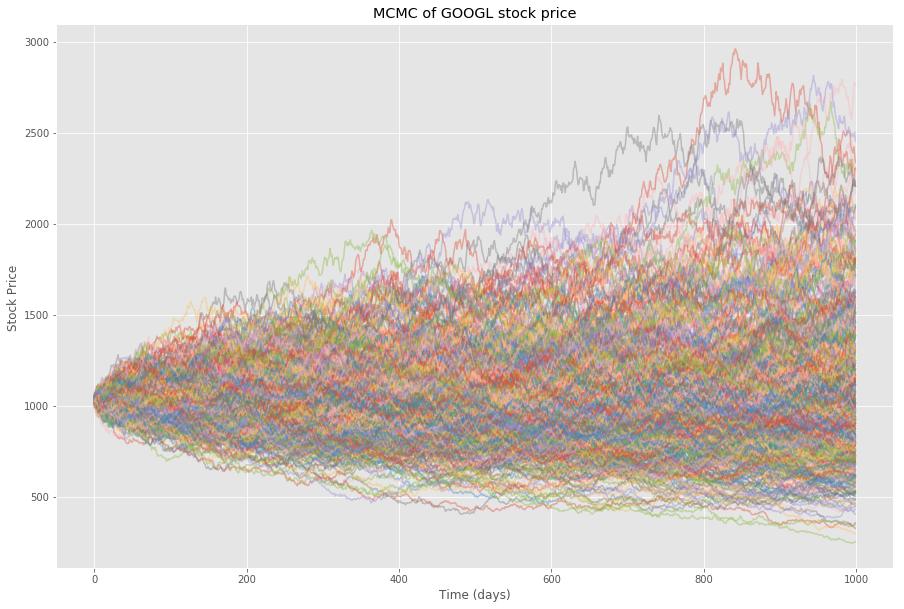

,Min. Price
Probability,
1.0,-inf
0.9,536.957213
0.8,723.644560
0.7,858.259271
0.6,973.282579
0.5,1080.792098
0.4,1188.301617
0.3,1303.324924
0.2,1437.939636


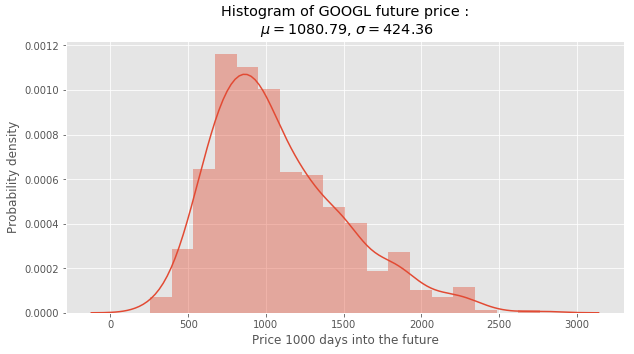

In [218]:
if __name__ == "__main__":

    #Ask user for comapnies ticker
    ticker = str(input("Company's Stock Ticker: "))
    days_predict = int(input('Prediction range (days): '))
    mcmc_sim = int(input('MCMC simulation (days): '))

    #Request YahooFinance library for companies historic data
    raw_data = yahoo_get(ticker, '2015-01-01', str(datetime.datetime.now().date()))
    plot_corr(raw_data, 10, 'Raw Data Correlation {}'.format(ticker))
    clean_data = feature_eng_yahoo(raw_data, days_predict)
    plot_stock(clean_data, 'Adj_Close', 15 ,'{} Stock Price'.format(ticker))
    plot_corr(clean_data, 10,'Clean Data Correlation {}'.format(ticker))
    
    #Train model and predict Close Stock Prices AAPL
    score, reg = LR_train(clean_data, days_predict)
    predictions, predicted_df = LR_predict(clean_data, reg, days_predict)
    plot_predictions(predicted_df,['future_price{}d'.format(days_predict), 'Predictions'] , 10, '{} Stock Predictions'.format(ticker))
    
    #Retrieve related tweets
    api = twitter()
    tweets = get_tweets_hash('#{}'.format(ticker), api)
    
    #Create summary dataframe
    stock_summary, pred = summary(clean_data, tweets, predictions,days_predict)
    
    #MCMC of stock
    mcmc(raw_data, mcmc_sim)